# Introduction to the project

### Description
This project explores different data pre-processing techniques for a text-based problem and how we can use several clustering algorithms and matrix operations to cluster text data.

For this project I used Google Play Store App reviews dataset from Kaggle (https://www.kaggle.com/datasets/prakharrathi25/google-play-store-reviews)

The project and the data can be found in a GitHub repo too: https://github.com/rat-sparebank1/dtsa_5510_project

The project compares the accuracies of the different scenarioes.

### Steps
I followed these steps:
* Read the data and import it as a Pandas dataframe
* Do some EDA to understand the structure of the data: counting values, value types, distribution and number of the different categories (scores) in the data (including visualization), the most common words (visualization)
* Make a list of stopwords
* Tokenize and vectorize the text columns
* Made some initial clustering with K-Means and get some accuracy metrics
* Improve data pre-processing by removing emojies, lemmatization and stemming
* Simplify the problem to only positive or negative reviews
* Use sentiment analysis instead of vectorization and using it as feature to make clusters
* Use other clustering algorithms as Agglomerative Clustering and Spectral Clustering
* Use supervised learning (RandomForest) and compare metrics with the results from the clustering algorithms (supervised vs unsupervised)

### Considerations and assumptions
* Review text data is more difficult to work with due to the lack of standards when writing reviews
* Many reviews are unrelated to the score given
* Some reviews are very short
* Many reviews use emojies to express sentiment
* Many typos
* This dataset includes reviews from different apps
* Assumption: TF-ID is an appropriate vectorization technique for this problem
* Assumption: K-Means random-state has only marginal impact at the results despite K-Means weakness regarding initialization values.

### Conclusions
* App reviews it more difficult to cluster than text that has been carefully edited (i.e. news articles, research documents, etc.)
* Emojies convey important information about sentiment, but they are more difficult to process (decoding)
* Sentiment analysis can add a feature that can be used to improve accuracy
* NMF (Non-negative Matrix Factorization) is extremely fast and gave similar accuracy than other more processor-intensive techniques
* Agglomerative Clustering performed really bad when it comes to processor time and I couldnt cluster the whole dataset at once
* RandomForest achieved the best accuracy. So access to labeled data helps
* Improved pre-processing can help a bit in improving accuracy for the models.

Some of the improvements I would have done to improve clustering:
1. Make clustering per application by using appId field
2. Decode the emojies instead of just removing them.
3. Make script to automate hyperparameter tuning for the different models

### References
Tokenize and vectorize text: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#

Scikit learn clustering: https://scikit-learn.org/stable/modules/clustering.html

Lemmatization examples: https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

How to make a wordcloud in python: https://www.geeksforgeeks.org/generating-word-cloud-python/

Using NLTK's Vader for sentiment analysis: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

## Accuracy comparison between models
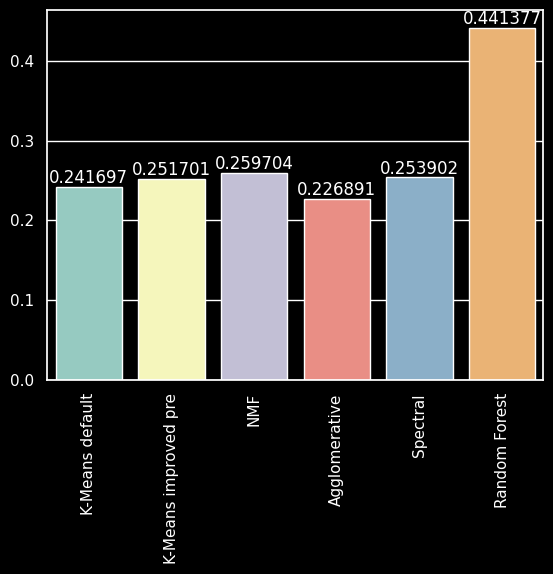

## Import dataset from Github repo

In [ ]:
!rm -rf /content/dtsa_5510_project
!rm -rf /content/reviews.csv
!git clone https://github.com/rat-sparebank1/dtsa_5510_project.git

Cloning into 'dtsa_5510_project'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 23 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (23/23), 3.13 MiB | 7.40 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## Extract dataset from zip file

In [ ]:
!unzip -q dtsa_5510_project/data/google_play_store_reviews.zip

## Import necessary packages

In [ ]:
## Installing emoji package
!pip install emoji

In [ ]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from collections import Counter
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download("wordnet")
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Read dataset in pandas dataframe

In [ ]:
df = pd.read_csv('reviews.csv')

## Basic EDA

In [ ]:
print(df.describe())

df.info()

print(df.columns)

print(df.head())

              score  thumbsUpCount
count  12495.000000   12495.000000
mean       3.094198       3.047459
std        1.457693      14.303903
min        1.000000       0.000000
25%        2.000000       0.000000
50%        3.000000       0.000000
75%        4.000000       1.000000
max        5.000000     397.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12495 non-null  object
 1   userName              12495 non-null  object
 2   userImage             12495 non-null  object
 3   content               12495 non-null  object
 4   score                 12495 non-null  int64 
 5   thumbsUpCount         12495 non-null  int64 
 6   reviewCreatedVersion  10333 non-null  object
 7   at                    12495 non-null  object
 8   replyContent          5818 non-null   object
 9   repliedAt            

## More EDA



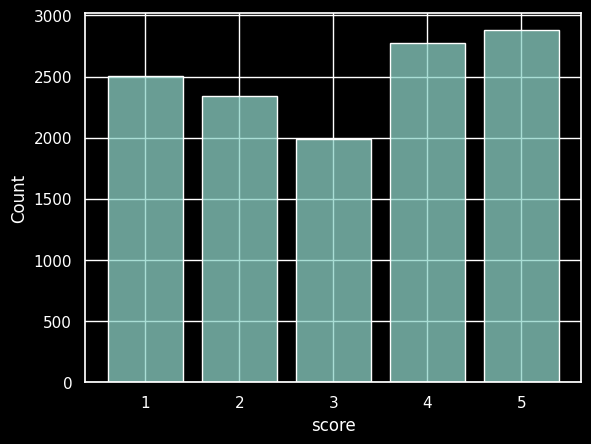

In [ ]:
scores = (df.score).astype('int')
sns.histplot(scores, discrete=True, shrink=.8)
plt.style.use("dark_background")
plt.show()

Using wordcloud to compare reviews rated 1 vs rated 5

In [ ]:


def generate_wordcloud(df_column):
  comment_words = ''
  stopwords = set(STOPWORDS)
  additional_stopwords = ['app', 'work']
  for word in additional_stopwords:
    stopwords.add(word)

  for val in df_column:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

  # plot the WordCloud image
  plt.figure(figsize = (4, 4), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

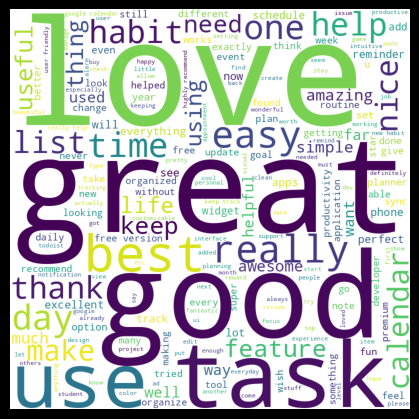

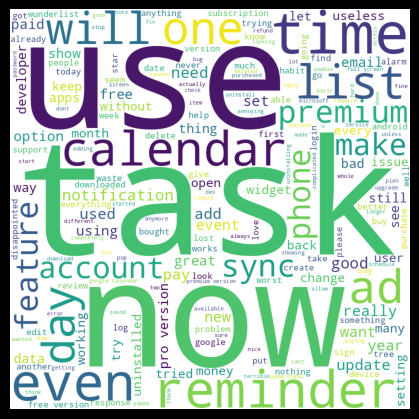

In [ ]:
top_review_art = df.loc[df.score == 5.0].content
bottom_review_art = df.loc[df.score == 1.0].content

generate_wordcloud(top_review_art)
generate_wordcloud(bottom_review_art)

## Print some examples of reviews based on score

In [ ]:
score_5 = df.loc[df.score == 5.0].content
score_3 = df.loc[df.score == 3.0].content
score_1 = df.loc[df.score == 1.0].content


# Print some reviews with score 5
print("Some reviews with score 5")
print(score_5.head())

# Print some reviews with score 3
print("Some reviews with score 3")
print(score_3.head())


# Print some reviews with score 1
print("Some reviews with score 1")
print(score_1.head())

Some reviews with score 5
750    This app is awesome. I am currently using the ...
751                                        Great product
752             Great app, helps me to plan my day ahead
753    This app is amazing, changed my life. I'm doin...
754                                          Good app 🙂👍
Name: content, dtype: object
Some reviews with score 3
400    This still works pretty well, but I'm not a fa...
401    Good app. Annoying pop up every morning on my ...
402    I haven't used they made an effort from there ...
403    29.9. Nothing new, I've already reconciled to ...
404    I've been a satisfied user of Any.do since Mar...
Name: content, dtype: object
Some reviews with score 1
0                        I cannot open the app anymore
1    I have been begging for a refund from this app...
2    Very costly for the premium version (approx In...
3    Used to keep me organized, but all the 2020 UP...
4                                  Dan Birthday Oct 28
Name: content, dtyp

### Use a counter to find the most frequent words

In [ ]:
counter = Counter()
punctuation = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
for sentence in df.content:
  words = word_tokenize(sentence.lower())
  words = [word for word in words if word not in punctuation]
  counter.update(words)



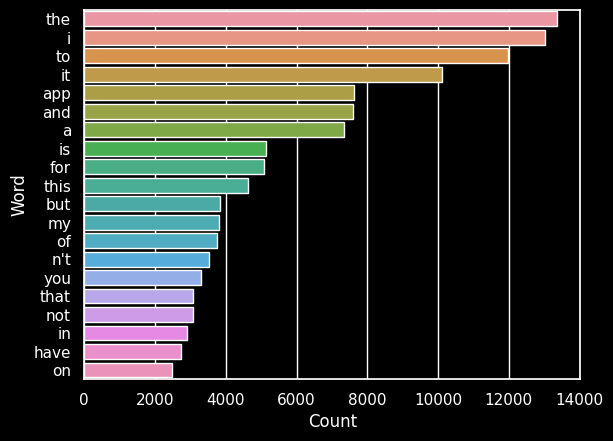

In [ ]:
most_common = counter.most_common(20)
words= []
number_words = []
df_frequency = pd.DataFrame(most_common, columns=['Word', 'Count'])
sns.barplot(data=df_frequency, x="Count", y="Word", orient = 'h', errorbar=None)
plt.style.use("dark_background")
plt.show()

### From the initial EDA analysis:
1. Some potential relevant features  are: score, content, replyContent, appId
2. Some issues and initial observations:
It seems that there is no NaN values in the content, score and appId values
No replyContent has been filled with "NaN"
Content field can have emojies and they give meaning and value
3. It could be added value to identify if the same user has given score to different apps, but (fortunately) this is not possible in this public dataset
4. Not all elements in content column are relevant. References to dates i.e. some very short reviews are relevants, but other don't
5. Another weakness in the data is that there is no reference to the app-version that has been reviewed. New versions with i.e. breaking changes or significant UI changes can produce lower scores/worse reviews
6. The word-cloud was not very useful this time. For top score reviews, the result was as expected, but not very useful for the bottom scores. It may be that for this dataset a better stopwords list should be prepared
7. The word count shows that the most frequent words are not very relevant and data should be clean (i.e. using stopwords)

## Cluster content and compare it to the score

In [ ]:
X = df.content
y_score = df.score
X_train, X_test, y_train, y_test = train_test_split(X, y_score, test_size=0.2, random_state=42)

## Tokenize and vectorize the text
I will use TF-ID because it can vectorize the text and at the same time give more weight to the words that are less frequent and the other way around for the more frequent words.

It produces a sparse matrix and some clustering functions from Scikit Learn work only with dense matrices so I will be converting it to dense matrices if needed (i.e. when using K-Means)

In [ ]:
## Defining a vectorizing method to be used throughout the notebook
def convertWithTfid(fit_data, X_train, X_test=None):
  vect = TfidfVectorizer(stop_words='english')
  vect.fit(fit_data)
  print("Word count both train and test: ", len(vect.vocabulary_))
  n_words = len(vect.vocabulary_)
  tf_vect = vect.transform(X_train)
  if X_test is not None:
    tf_vect_test = vect.transform(X_test)
    return tf_vect, tf_vect_test
  else:
    return tf_vect

In [ ]:
tf_vect, tf_vect_test = convertWithTfid(df.content, X_train, X_test)

Word count both train and test:  11990


In [ ]:
# Using permutation method from the lab from Week 2 since we know the scores

def label_permute_compare(ytdf,yp,n=5):
    unique_labels_string = ytdf.unique()
    pred_labels = yp
    permutations = list(itertools.permutations(range(n)))
    max_equal_labels = 0
    max_dict = {}
    max_perm = None
    for perm in permutations:
        dictionary = make_dict(unique_labels_string, perm)
        true_labels = ytdf.replace(dictionary)
        equal_labels = np.sum(true_labels == pred_labels)
        if equal_labels > max_equal_labels:
            max_perm = perm
            max_equal_labels = equal_labels
            max_dict = dictionary
    accuracy = max_equal_labels/len(true_labels)
    return max_perm, max_dict, accuracy

def make_dict(labels_string, perm):
    label_dict = {}
    for string_label, perm_label in zip(labels_string, perm):
        label_dict[string_label] = perm_label
    return label_dict

## Using K-Means to try to cluster the data
I will be mostly using K-Means to try to cluster the data. K-Means can be sensitive to initial conditions. I will try using "k-means++" that according to the documentation, can improve initialization and make the clustering more robust. My own impression is in this case that it helps marginally.
I have tried to use different seed values ( from 0 to 5 in in random state) and found that 3 is the best for this case.  

In [ ]:

tf_array = tf_vect.toarray()
kmeans = KMeans(
      n_clusters=5,
      init='k-means++',
      max_iter=100,
      n_init=1,
      random_state=3,
  ).fit_predict(tf_array)



In [ ]:
print(kmeans)
print(np.unique(kmeans, return_counts=True))

[3 3 3 ... 0 0 0]
(array([0, 1, 2, 3, 4], dtype=int32), array([7090,  311,  140, 2283,  172]))


By finding out the distribution of the predicted values one can see that most values has been assigned to two clusters (but we already know that the data is more or less balanced)

In [ ]:
labelorder, dictionary, acc_kmeans_default = label_permute_compare(y_train, kmeans)
print(dictionary, acc_kmeans_default)

{4: 3, 3: 1, 5: 4, 1: 0, 2: 2} 0.2416966786714686


Performance is poor and the model is just assigning many reviews to a cluster and the accuracy shown is marginally better than clustering all information in one cluster

## Improve tokenization and vectorization
I will try to improve data preprocessing. This can be done by better removing  stopwords, removing emojies, lemmatization and stemming.
* Stopwords are those words that are used very often in sentences, but that don't give that huge value when it comes to classify or clustering text i.e. "for", "to", "in", etc.
* Emojies has been removed since in their encoded representation, does not help to cluster the data. With better time, one could try to convert the emojies from the encoded representation to i.e. the name of the emojies. This approach could help to add helpful information, but not all emojies has standard descriptions, so the fastest approach is to remove them
* Lemmatization is the process of assigning one word for words that are bassically the same
* Stemming is the process to remove suffixes to words in a way that we only consider their stem i.e. "walk", "walked", "walking" become only "walk"





In [ ]:
df_improved = df

### Removing emojies

In [ ]:
df_improved.content = df_improved.content.apply(lambda x: emoji.replace_emoji(x, ''))

### Make a list stopwords using NLTK

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

### Lemmatizing the text

In [ ]:
def lemmatize_stem(sentence):
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  words = word_tokenize(sentence)
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  stemmed_words = [stemmer.stem(word) for word in lemmatized_words]
  return ' '.join(stemmed_words)

df_improved.content = df_improved.content.apply(lambda x: lemmatize_stem(x))


In [ ]:
print(df_improved.content.head())

0                        i can not open the app anymor
1    i have been beg for a refund from thi app for ...
2    veri costli for the premium version ( approx i...
3    use to keep me organ , but all the 2020 updat ...
4                                  dan birthday oct 28
Name: content, dtype: object


In [ ]:
X = df_improved.content
y = df_improved.score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf_vect, tf_vect_test = convertWithTfid(df.content, X_train, X_test)

Word count both train and test:  8954


In [ ]:
tf_array = tf_vect.toarray()
kmeans = KMeans(
      n_clusters=5,
      init='k-means++',
      max_iter=100,
      n_init=1,
      random_state=3,
  ).fit_predict(tf_array)

In [ ]:
print(kmeans)
print(np.unique(kmeans, return_counts=True))

[2 2 0 ... 0 0 0]
(array([0, 1, 2, 3, 4], dtype=int32), array([6816,  358, 1143, 1032,  647]))


In [ ]:
labelorder, dictionary, acc_no_emojies_lem_stem = label_permute_compare(y_train, kmeans)
print(dictionary, acc_no_emojies_lem_stem)

{4: 2, 3: 1, 5: 4, 1: 0, 2: 3} 0.25170068027210885


In [ ]:
# Saving array and y_train to later use:
tf_sparse_agg = tf_vect
tf_array_agg = tf_array
y_train_agg = y_train

Better pre-processing helps to improve accuracy marginally

## Using NMF

In [ ]:
n_scores = 5
nmf = NMF(n_components=n_scores, random_state=42, init='random')

In [ ]:
W = nmf.fit_transform(tf_vect)
H = nmf.components_

In [ ]:
y_pred = np.argmax(W, axis=1)
labelorder, dictionary, acc_nmf = label_permute_compare(y_train, y_pred)
print(dictionary, acc_nmf)

{4: 3, 3: 1, 5: 2, 1: 4, 2: 0} 0.25970388155262103


Using Non-negative matrix factorization improves accuracy a tiny bit, but the process is definitely much faster

### Simplify the problem

Since app reviews are not a standard text bound to editorial rules, and people will assign different scores with wide variations in language use, one could try to divide the data in positive and negative reviews.

All reviews over 3 will be classified as "positive" and all reviews under 3 will be classified as "negative". Reviews with score 3 will be consider neutral.

To make the problem simplier, those reviews will be remove from the dataset.

In [ ]:
# Removing all reviews with score 3 from the database

df_pos_neg = df_improved.drop(df[df['score'] == 3.0].index)

In [ ]:
# Splitting data in train and test
X = df_pos_neg.content
y_score = df_pos_neg.score
X_train, X_test, y_train, y_test = train_test_split(X, y_score, test_size=0.2, random_state=42)

In [ ]:
# Replace scores 1 and 2 with 0 and 4 and 5 with 1

y_train[y_train == 1.0] = 0.0
y_train[y_train == 2.0] = 0.0
y_train[y_train == 4.0] = 1.0
y_train[y_train == 5.0] = 1.0

In [ ]:
tf_vect, tf_vect_test = convertWithTfid(df.content, X_train, X_test)

Word count both train and test:  8954


In [ ]:
# Using K-Means, but the number of clusters is only 2 since we only have positive and negative review clusters
tf_array = tf_vect.toarray()
kmeans = KMeans(
      n_clusters=2,
      init='k-means++',
      max_iter=100,
      n_init=1,
      random_state=4,
  ).fit_predict(tf_array)

In [ ]:
print(kmeans)
print(np.unique(kmeans, return_counts=True))

[0 1 1 ... 1 0 0]
(array([0, 1], dtype=int32), array([7508,  895]))


In [ ]:
labelorder, dictionary, acc_simplified = label_permute_compare(y_train, kmeans)
print(dictionary, acc_simplified)

{0: 0, 1: 1} 0.5464714982744258


This approach did not help that much either. The accuracy calculated for 2 clusters is just better than random assignment (50% chance)

### Try adding sentiment analysis:
My thoughts are using feature engineering to add a new feature "sentiment" based on a rule-based tool as Vader to analyze how negative or positive a sentence is based on these rules.
Then use this feature to help cluster the reviews. My hypothesis is that app scores are directly correlated to sentiment scores

In [ ]:
df_sentiment = df_improved

In [ ]:
def analyzeSentiment(sentence):
  sentiment_analyzer = SentimentIntensityAnalyzer()
  sentiment_scores = sentiment_analyzer.polarity_scores(sentence)
  return sentiment_scores['compound']

In [ ]:
df_sentiment.sentiment = df_sentiment.content.apply(analyzeSentiment)

<ipython-input-69-173f54d16557>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_sentiment.sentiment = df_sentiment.content.apply(analyzeSentiment)


In [ ]:
# Splitting data in train and test
X = df_sentiment.sentiment
y = df_sentiment.score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
kmeans = KMeans(
      n_clusters=5,
      init='k-means++',
      max_iter=100,
      n_init=1,
      random_state=1,
  ).fit_predict(X_train.values.reshape(-1, 1))

In [ ]:
labelorder, dictionary, acc_sentiment = label_permute_compare(y_train, kmeans)
print(dictionary, acc_sentiment)

{4: 0, 3: 4, 5: 2, 1: 3, 2: 1} 0.304921968787515


### Another approach is to change the clustering algorithm and using Hierarchical Clustering i.e. Agglomerative Clustering

I try this but soon discovered that 12K samples to cluster at once was too many. This weakness comes from the fact that the algorithm will try to compare pair-wise distances between all samples and this works ok with small number of samples.

To overcome this I sample the data to 1/6 of the size just to be able to use this method. In a real situation, I could have created a batching rutine and try to run clustering in batches to go through all the dataset in several rounds

In [ ]:
tf_array_sample = tf_array_agg[::6,:]
agg_cluster = AgglomerativeClustering(n_clusters=5)
agg_cluster.fit_predict(tf_array_sample)
print(agg_cluster.labels_)

[0 0 0 ... 0 0 0]


In [ ]:
y_sample = y_train_agg.iloc[::6]
labelorder, dictionary, acc_agg = label_permute_compare(y_sample, agg_cluster.labels_)
print(dictionary, acc_agg)

{4: 0, 3: 1, 5: 2, 2: 3, 1: 4} 0.226890756302521


### Trying with Spectral Clustering too

In [ ]:
spectral = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=0).fit(tf_sparse_agg)

In [ ]:
labelorder, dictionary, acc_spectral = label_permute_compare(y_train_agg, spectral.labels_)
print(dictionary, acc_spectral)

{4: 1, 3: 2, 5: 0, 1: 4, 2: 3} 0.2539015606242497


## Try classification (supervised learning)

And at the end, we can compare accuracy of making predictions using a classifier instead.

In [ ]:
# Splitting data in train and test
X = df_improved.content
y = df_improved.score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf_vect, tf_vect_test = convertWithTfid(df.content, X_train, X_test)

Word count both train and test:  8954


In [ ]:
forest = RandomForestClassifier()
forest.fit(tf_vect, y_train)
y_pred = forest.predict(tf_vect_test)

labelorder, dictionary, acc = label_permute_compare(y_test, y_pred)


In [ ]:
acc_supervised = metrics.accuracy_score(y_test, y_pred)
print(acc_supervised)

0.4413765506202481


## Comparing the accuracies achieved by the different approaches


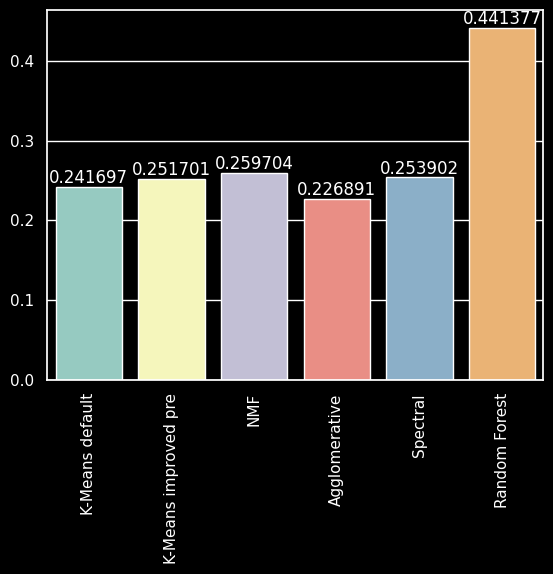

In [ ]:
accuracies = [acc_kmeans_default, acc_no_emojies_lem_stem, acc_nmf, acc_agg, acc_spectral, acc_supervised]
x_labels = ["K-Means default", "K-Means improved pre", "NMF", "Agglomerative", "Spectral", "Random Forest"]


ax = sns.barplot(y=accuracies, x=x_labels, errorbar=None)

for i in ax.containers:
    ax.bar_label(i,)
plt.xticks(rotation=90)
plt.style.use("dark_background")
plt.show()